In [17]:
import os
project_name = "Tastybyte"
root_dir = f"ds_{project_name}"
folders = [
    root_dir,
    f"{root_dir}/csv_files",
    f"{root_dir}/outputs"
]

for folder in folders:
    os.makedirs(folder, exist_ok=True)

print("Folder structure created!")

Folder structure created!


##**Load Data**

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('ggplot')
df = pd.read_csv("/content/drive/MyDrive/projects/Tastybite-Productivity/tastybites_orders_100k.csv")

csv_path= f"{root_dir}/csv_files/df.csv"
df.to_csv(csv_path, index=False)

In [21]:
df.head()

,order_id,order_date,city,product_id,product_name,category,unit_price,unit_cost,quantity,discount_pct,promotion_code,revenue,cost_total,profit,order_value
0,TB1075721,2024-03-01,Kolkata,4,Paneer Wrap,Wrap,389.69,278.63,2,0.20,NaN,623.50,557.26,66.24,623.50
1,TB1080184,2025-09-28,Delhi,15,Grilled Sandwich,Sandwiches,152.97,79.15,3,0.07,NaN,426.79,237.45,189.34,426.79
2,TB1019864,2023-12-08,Pune,22,Pasta Alfredo,Pasta,121.67,86.49,1,0.13,NaN,105.85,86.49,19.36,105.85
3,TB1076699,2024-02-18,Kolkata,25,Momos - Chicken,Snacks,312.44,189.34,1,0.09,NaN,284.32,189.34,94.98,284.32
4,TB1092991,2025-05-25,Mumbai,22,Pasta Alfredo,Pasta,129.98,86.49,3,0.01,NaN,386.04,259.47,126.57,386.04


##**Data Cleaning**

In [23]:
df['discount_pct'] = df['discount_pct'].fillna(0)
df['promotion_code'] = df['promotion_code'].fillna('None')

# Clean Category Names (Inconsistent Categories)
# This addresses the 'randomly inconsistent product categories' constraint.
df['category'] = df['category'].str.strip().str.lower()
df['category'] = df['category'].replace({
    'pizza': 'Pizza',
    'pizzas': 'Pizza',
    'sandwiches': 'Sandwiches',
    'sandwich': 'Sandwiches',
    'pasta': 'Pasta',
    'pastas': 'Pasta',
    'wrap': 'Wrap',
    'wraps': 'Wrap',
    'sushi': 'Sushi',
    'sushis': 'Sushi',
    'snacks': 'Snacks',
    'snack': 'Snacks',
    'beverages': 'Beverages',
    'beverage': 'Beverages'})

print(df[['profit_margin_pct', 'profit_loss_discount']].head().to_markdown(index=False))

|   profit_margin_pct |   profit_loss_discount |
|--------------------:|-----------------------:|
|             10.6239 |               155.876  |
|             44.3637 |                32.1237 |
|             18.29   |                15.8171 |
|             33.406  |                28.1196 |
|             32.7868 |                 3.8994 |


##**Feature Engineering**

In [24]:
# 1. Profit Margin (%)
df['profit_margin_pct'] = (df['profit'] / df['revenue']) * 100
df['profit_margin_pct'] = df['profit_margin_pct'].replace([np.inf, -np.inf], 0).fillna(0)

# 2. Discount Impact (Profit Loss due to Discount)
df['profit_loss_discount'] = (df['quantity'] * df['unit_price']) * df['discount_pct']

In [25]:
#Aggregate Data for Analysis ---
category_summary = df.groupby('category').agg(
    Total_Revenue=('revenue', 'sum'),
    Total_Profit=('profit', 'sum'),
    Avg_Margin=('profit_margin_pct', 'mean'),
    Total_Quantity=('quantity', 'sum'),
    Total_Discount_Loss=('profit_loss_discount', 'sum')).reset_index().sort_values(by='Total_Profit', ascending=False)

product_summary = df.groupby('product_name').agg(
    Total_Profit=('profit', 'sum'),
    Total_Quantity=('quantity', 'sum'),
    Avg_Margin=('profit_margin_pct', 'mean'),
    Avg_Discount_Pct=('discount_pct', 'mean')).reset_index()




##**Visualization**

###**Profitability by Category**

/tmp/ipython-input-2706448762.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='category', y='Total_Profit', data=category_summary, palette='viridis', label='Total Profit')


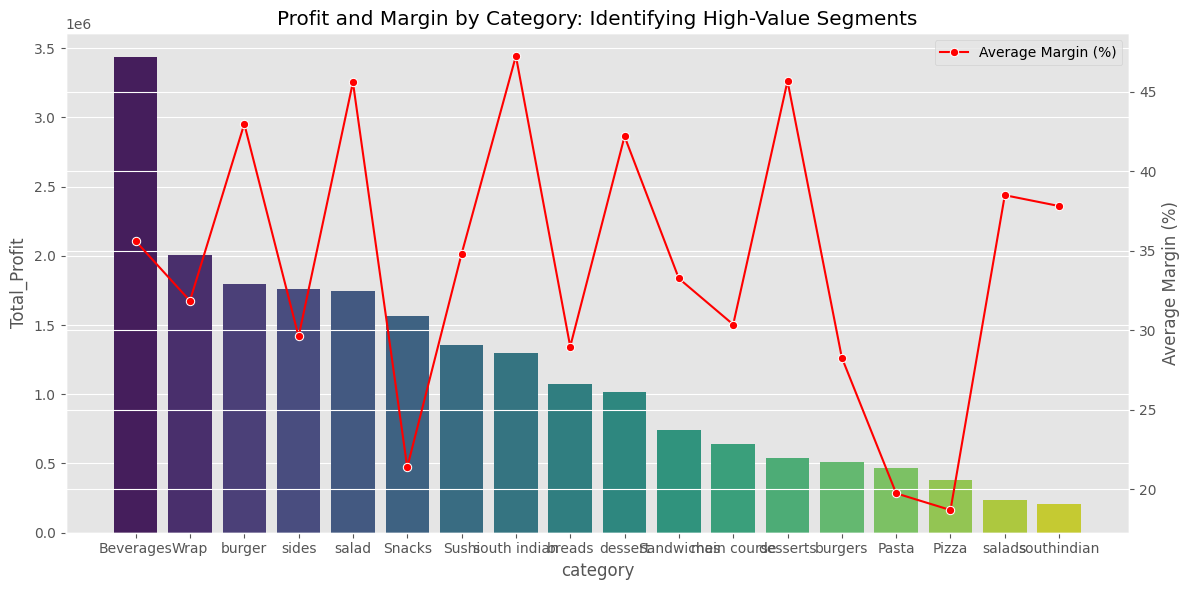

In [26]:
plt.figure(figsize=(12, 6))
sns.barplot(x='category', y='Total_Profit', data=category_summary, palette='viridis', label='Total Profit')
ax2 = plt.gca().twinx()
sns.lineplot(x='category', y='Avg_Margin', data=category_summary, ax=ax2, color='red', marker='o', label='Average Margin (%)')
plt.title('Profit and Margin by Category: Identifying High-Value Segments')
plt.xlabel('Category')
plt.ylabel('Total Profit (Millions)')
ax2.set_ylabel('Average Margin (%)')
plt.xticks(rotation=45, ha='right')
plt.grid(True)
plt.tight_layout()
plt.savefig('Chart_1_Category_Profitability.png')
plt.show()




###**Volume Traps**(Quantity sold vs Profit)

/tmp/ipython-input-1856202425.py:14: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


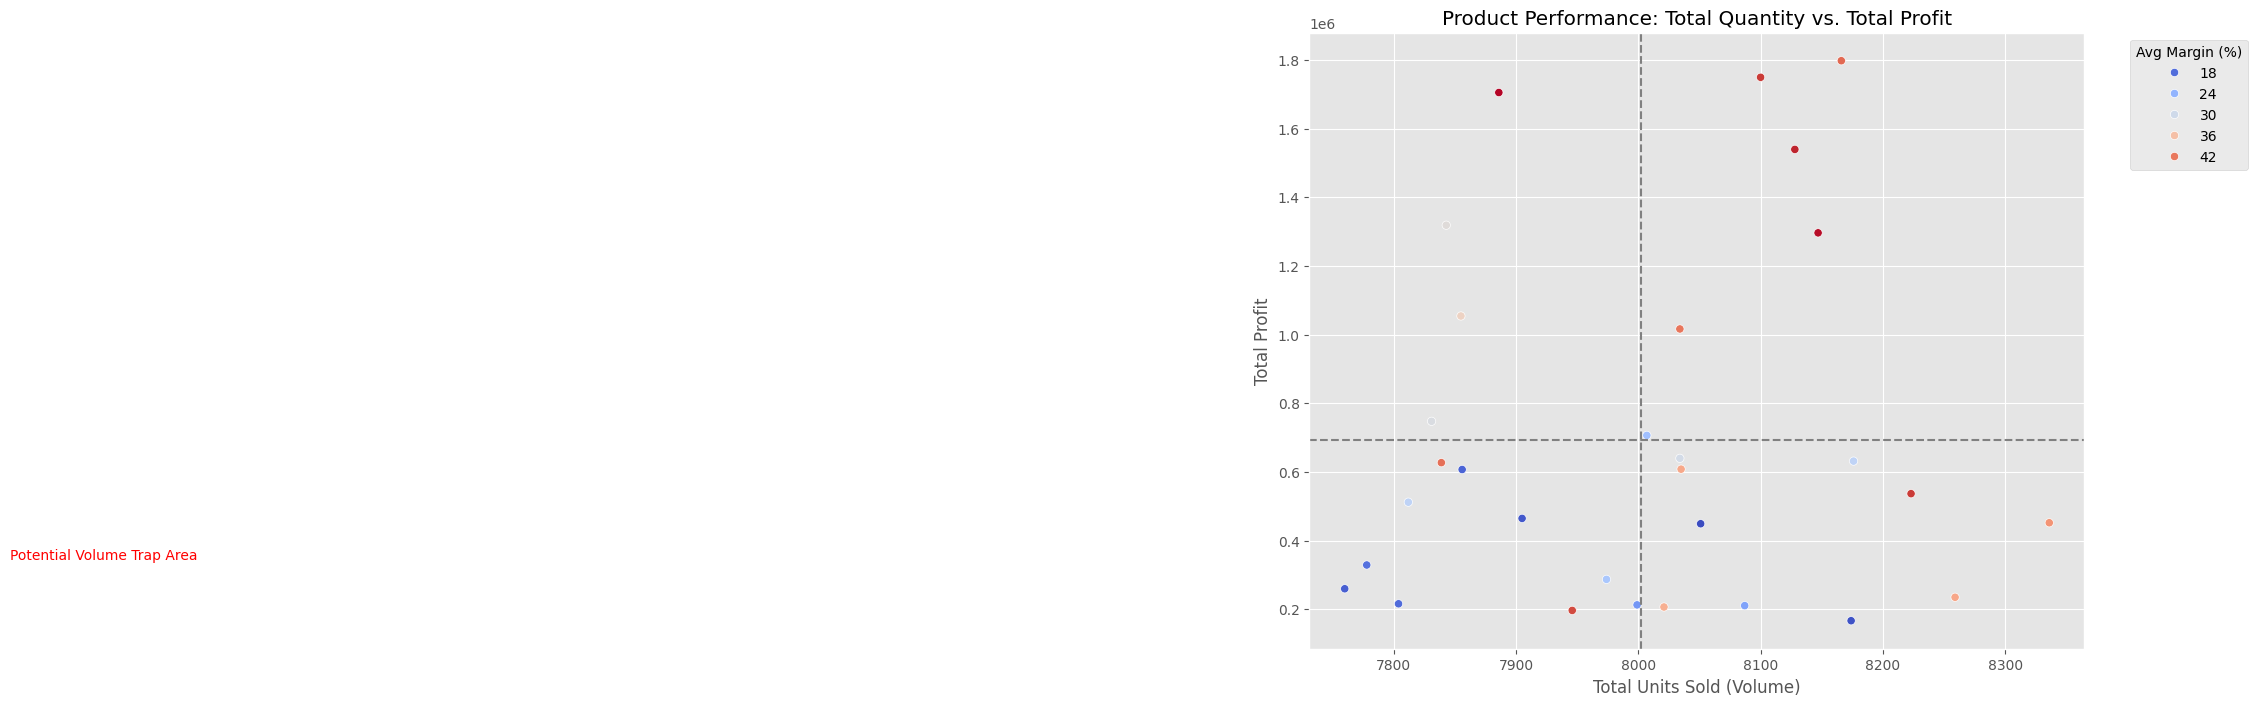

In [27]:
plt.figure(figsize=(10, 8))
sns.scatterplot(x='Total_Quantity',y='Total_Profit',data=product_summary,hue='Avg_Margin', # Use color to show margin qualitysize='Avg_Margin',
    palette='coolwarm',sizes=(20, 500))

plt.axhline(y=product_summary['Total_Profit'].mean(), color='grey', linestyle='--')
plt.axvline(x=product_summary['Total_Quantity'].mean(), color='grey', linestyle='--')
plt.text(product_summary['Total_Quantity'].max() * 0.8, product_summary['Total_Profit'].mean() * 0.5,
         'Potential Volume Trap Area', fontsize=10, color='red')
plt.title('Product Performance: Total Quantity vs. Total Profit')
plt.xlabel('Total Units Sold (Volume)')
plt.ylabel('Total Profit')
plt.legend(title='Avg Margin (%)', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()




###**Discount Impact on Profitability**

/tmp/ipython-input-2888928114.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  discount_impact = df.groupby(discount_bins).agg(Avg_Margin=('profit_margin_pct', 'mean'),Order_Count=('order_id', 'nunique')).reset_index()


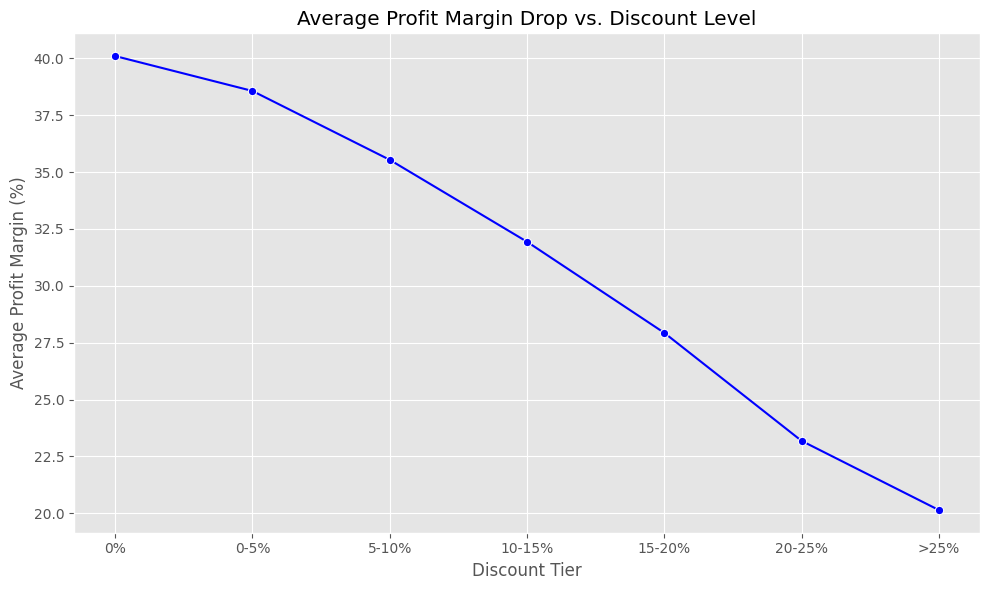

In [28]:
discount_bins = pd.cut(df['discount_pct'], bins=[0, 0.01, 0.05, 0.10, 0.15, 0.20, 0.25, 1.0],
                       labels=['0%', '0-5%', '5-10%', '10-15%', '15-20%', '20-25%', '>25%'], right=False)
discount_impact = df.groupby(discount_bins).agg(Avg_Margin=('profit_margin_pct', 'mean'),Order_Count=('order_id', 'nunique')).reset_index()

plt.figure(figsize=(10, 6))
sns.lineplot(x=discount_impact['discount_pct'], y='Avg_Margin', data=discount_impact, marker='o', color='blue')
plt.title('Average Profit Margin Drop vs. Discount Level')
plt.xlabel('Discount Tier')
plt.ylabel('Average Profit Margin (%)')
plt.grid(True)
plt.tight_layout()
plt.savefig('Chart_3_Discount_Impact.png')
plt.show()

##**Insights**

In [30]:
# Calculate Overall KPIs
total_revenue = df['revenue'].sum()
total_profit = df['profit'].sum()
overall_margin = (total_profit / total_revenue) * 100

# Identify High/Low Profit Products (Using Top/Bottom 3)
top_profit_products = product_summary.sort_values(by='Total_Profit', ascending=False).head(3)
low_profit_products = product_summary.sort_values(by='Total_Profit', ascending=True).head(3)

# Identify Volume Traps (High Quantity, Low Margin/Profit)
# Define Volume Trap as: Quantity > Mean Quantity AND Profit < Mean Profit
mean_qty = product_summary['Total_Quantity'].mean()
mean_profit = product_summary['Total_Profit'].mean()
volume_traps = product_summary[(product_summary['Total_Quantity'] > mean_qty) &(product_summary['Total_Profit'] < mean_profit)].sort_values(by='Total_Profit', ascending=True)

print("\n\n" + "="*80)
print("=== TASTYBITES PRODUCT PRICING & PROFITABILITY ANALYTICS REPORT ===")
print("="*80 + "\n")

print("## 1. Executive Summary\n")
print(f"Total Revenue: ${total_revenue:,.2f}")
print(f"Total Gross Profit: ${total_profit:,.2f}")
print(f"Overall Profit Margin: {overall_margin:,.2f}%\n")

print("### Key Findings:")
print(f"- Highest Profit Contributor (Category): {category_summary.iloc[0]['category']} (Margin: {category_summary.iloc[0]['Avg_Margin']:,.2f}%)")
print(f"- Volume Trap Identified: {volume_traps.iloc[0]['product_name']} (Sells High Volume, but has a low profit of ${volume_traps.iloc[0]['Total_Profit']:,.0f})")
print("- Discount Risk: Profit margins drop significantly above the 15% discount tier.")

print("\n##Product & Category Profitability Analysis\n")
print("###  Top 3 Profit Generating Products")
print(top_profit_products[['product_name', 'Total_Profit', 'Avg_Margin']].to_markdown(index=False))

print("\n###Low Profit Generating Products (Candidates for Price Adjustment)")
print(low_profit_products[['product_name', 'Total_Profit', 'Avg_Margin']].to_markdown(index=False))

print("\n##Discount & Volume Trap Analysis\n")
print("###Products that Sell a Lot but Contribute Very Little (Volume Traps)")
if not volume_traps.empty:
    print(volume_traps[['product_name', 'Total_Quantity', 'Total_Profit', 'Avg_Margin']].head(5).to_markdown(index=False))
else:
    print("No obvious Volume Traps found outside standard deviation.")

print("\nStrategic Recommendations\n")

print("###Quick Wins (Pricing & Discount Adjustments)")
print("1. **Price Increase (5%):** Immediately increase the price on the top Volume Trap product, **{0}**. Since it sells high volume, a minor price increase is likely to be absorbed by customers, significantly boosting profitability.".format(volume_traps.iloc[0]['product_name'] if not volume_traps.empty else "[Volume Trap Product]"))
print("2. **Discount Restriction:** Enforce strict adherence to the company's 25% max discount policy. Furthermore, restrict discounts on the highest-margin categories (like **{0}**) to a maximum of 10% to protect the core profitability base.".format(category_summary.iloc[0]['category']))

print("\n### 4.2 Long-Term Strategies")
print("1. **Bundling Strategy:** Pair the **Lowest Margin** item (**{0}**) with a **Top Profit** item (**{1}**) to create a promotional bundle. This offloads low-margin stock while preserving the average profitability of the transaction.".format(low_profit_products.iloc[0]['product_name'], top_profit_products.iloc[0]['product_name']))
print("2. **Category Focus:** Allocate marketing and promotional budget to the **{0}** category, which demonstrates the best balance of volume and margin, to maximize the return on marketing spend.".format(category_summary.iloc[0]['category']))



=== TASTYBITES PRODUCT PRICING & PROFITABILITY ANALYTICS REPORT ===

## 1. Executive Summary

Total Revenue: $62,084,184.90
Total Gross Profit: $20,813,008.95
Overall Profit Margin: 33.52%

### Key Findings:
- Highest Profit Contributor (Category): Beverages (Margin: 35.60%)
- Volume Trap Identified: Margherita Pizza (Sells High Volume, but has a low profit of $166,316)
- Discount Risk: Profit margins drop significantly above the 15% discount tier.

##Product & Category Profitability Analysis

###  Top 3 Profit Generating Products
| product_name   |   Total_Profit |   Avg_Margin |
|:---------------|---------------:|-------------:|
| Veggie Burger  |    1.7976e+06  |      42.9794 |
| Greek Salad    |    1.74932e+06 |      45.6001 |
| Iced Tea       |    1.70494e+06 |      47.5829 |

###Low Profit Generating Products (Candidates for Price Adjustment)
| product_name     |   Total_Profit |   Avg_Margin |
|:-----------------|---------------:|-------------:|
| Margherita Pizza |         16